In [9]:
path = '/content/drive/MyDrive/train'

In [10]:
!pip install -Uqq fastbook

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 1.2MB 16.7MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 
     |████████████████████████████████| 194kB 26.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 61kB 9.0MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 243kB/s 
ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.


In [11]:
import fastbook
# fastbook.setup_book()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#necessary imports to work with fastai
from fastbook import *
from fastai.vision.widgets import *
from matplotlib import pyplot
from matplotlib.image import imread
import pandas as pd

from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

In [ ]:
"""
This fastai DataBlock is used to create our own custom dataset, this has some cool features which helps in reducing the redundancy while creating dataset.
blocks are tuple of (dependent, independent) variables which generally means our image and the label.
get_image_files : gets the files from the path
splitter function splits the dataset into validation set and training set.
get_y : this is nice features it makes the label as the parent folder name(I used one script to make the folder names the corresponding datalabels)
item_tfms : used to transform the images
aug_tranforms : used for augmentations, fastai helps in maintaining the quality of the image.
"""
AlphaNumeric = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [ ]:
dls = AlphaNumeric.dataloaders(path)

In [ ]:
x,y = dls.one_batch()

In [ ]:
#this shows the different category available
dls.vocab

['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'small_a', 'small_b', 'small_c', 'small_d', 'small_e', 'small_f', 'small_g', 'small_h', 'small_i', 'small_j', 'small_k', 'small_l', 'small_m', 'small_n', 'small_o', 'small_p', 'small_q', 'small_r', 'small_s', 'small_t', 'small_u', 'small_v', 'small_w', 'small_x', 'small_y', 'small_z']

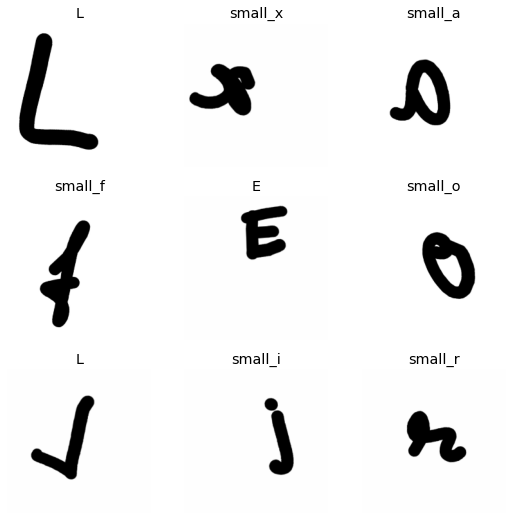

In [ ]:
#this shows one batch selected
dls.show_batch()

USING PRETRAINED MODEL FOR LATTER COMPARISON

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(10)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,accuracy,time
0,4.499744,2.444328,0.370968,14:31


epoch,train_loss,valid_loss,accuracy,time
0,2.150230,1.144368,0.685484,19:10
1,1.668279,0.743318,0.774194,18:56
2,1.317132,0.680505,0.794355,19:00
3,1.074530,0.525246,0.826613,19:04
4,0.866236,0.540568,0.842742,19:03
5,0.690946,0.458485,0.844758,19:04
6,0.578833,0.485659,0.856855,19:03
7,0.490123,0.446151,0.864919,18:59
8,0.421423,0.430002,0.864919,18:59
9,0.365451,0.424381,0.870968,19:04


In [ ]:
#we could see that the learner got 87% accuracy for 10 epochs, behind the scene this one learner is using cross-entropy loss
#plus there is adaptive learning rate calculator which goes down at each iteration.
#we used this pre-trained classifier to compare with the model we will build.

In [ ]:
#In 2015 the researcher Leslie Smith came up with a brilliant idea, called the learning rate finder
#we can use that too to find the optimum learning rate for our classifier.
#lr_min,lr_steep = learn.lr_find()

#As seen in https://arxiv.org/abs/1411.1792, this paper explains that why we should use a lower learning rate for the early layers of the neural network, and a higher learning rate for the later layers. 
#If we look at the layers the first few layers detect's small details like the edges/pattern etc while the last layers learn objects like cars etc. Called : discriminative learning rates. 
#We can pass the learning rate as a slice which means slice(a,b) a lr is used for earlier layers while b is used for latter layers. 
#learn.fit_one_cycle(12, lr_max=slice(1e-6,1e-4))

In [ ]:
#learn.recorder.plot_loss() can be used to plot the loss of train and validation set we can check what the data is performing if it's overfitting or underfitting.
# We can pass freeze_epochs to tell fastai how many epochs to train for while frozen. It will automatically change learning rates appropriately for most datasets..
# half-precision floating point, helps in memory efficiency using GPU's.

# from fastai.callback.fp16 import *
# learn = cnn_learner(dls, resnet50, metrics=error_rate).to_fp16()
# learn.fine_tune(6, freeze_epochs=3)

USING CUSTOM MODELS USING FASTAI

In [ ]:
# NOTE TO SELF : PurePath subclass that can make system calls. os.something one's
# Path
# from nbdev.showdoc import * test modules like assertions etc

MODEL : ResNet18

In [ ]:
body = create_body(resnet18, pretrained=False)
head = create_head(nf=512,n_out=62)
model = nn.Sequential(body,head)

# metr = [accuracy]
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),metrics=accuracy)

#let's run for 10 epochs
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,4.258596,5.186469,0.022177,00:45
1,3.956212,11.648857,0.028226,00:45
2,3.441362,5.675519,0.074597,00:45
3,2.853098,2.049060,0.372984,00:44
4,2.336695,2.924549,0.250000,00:45
5,1.935734,1.438203,0.586694,00:45
6,1.603912,1.158514,0.655242,00:45
7,1.361868,1.118893,0.679435,00:45
8,1.194687,0.876466,0.756048,00:45
9,1.073751,0.851849,0.772177,00:45


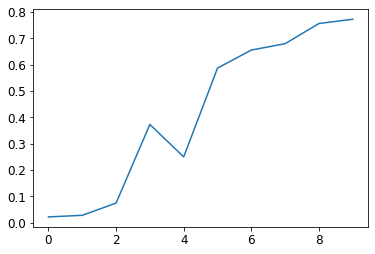

In [ ]:

plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
#we could see there was some imbalance here!

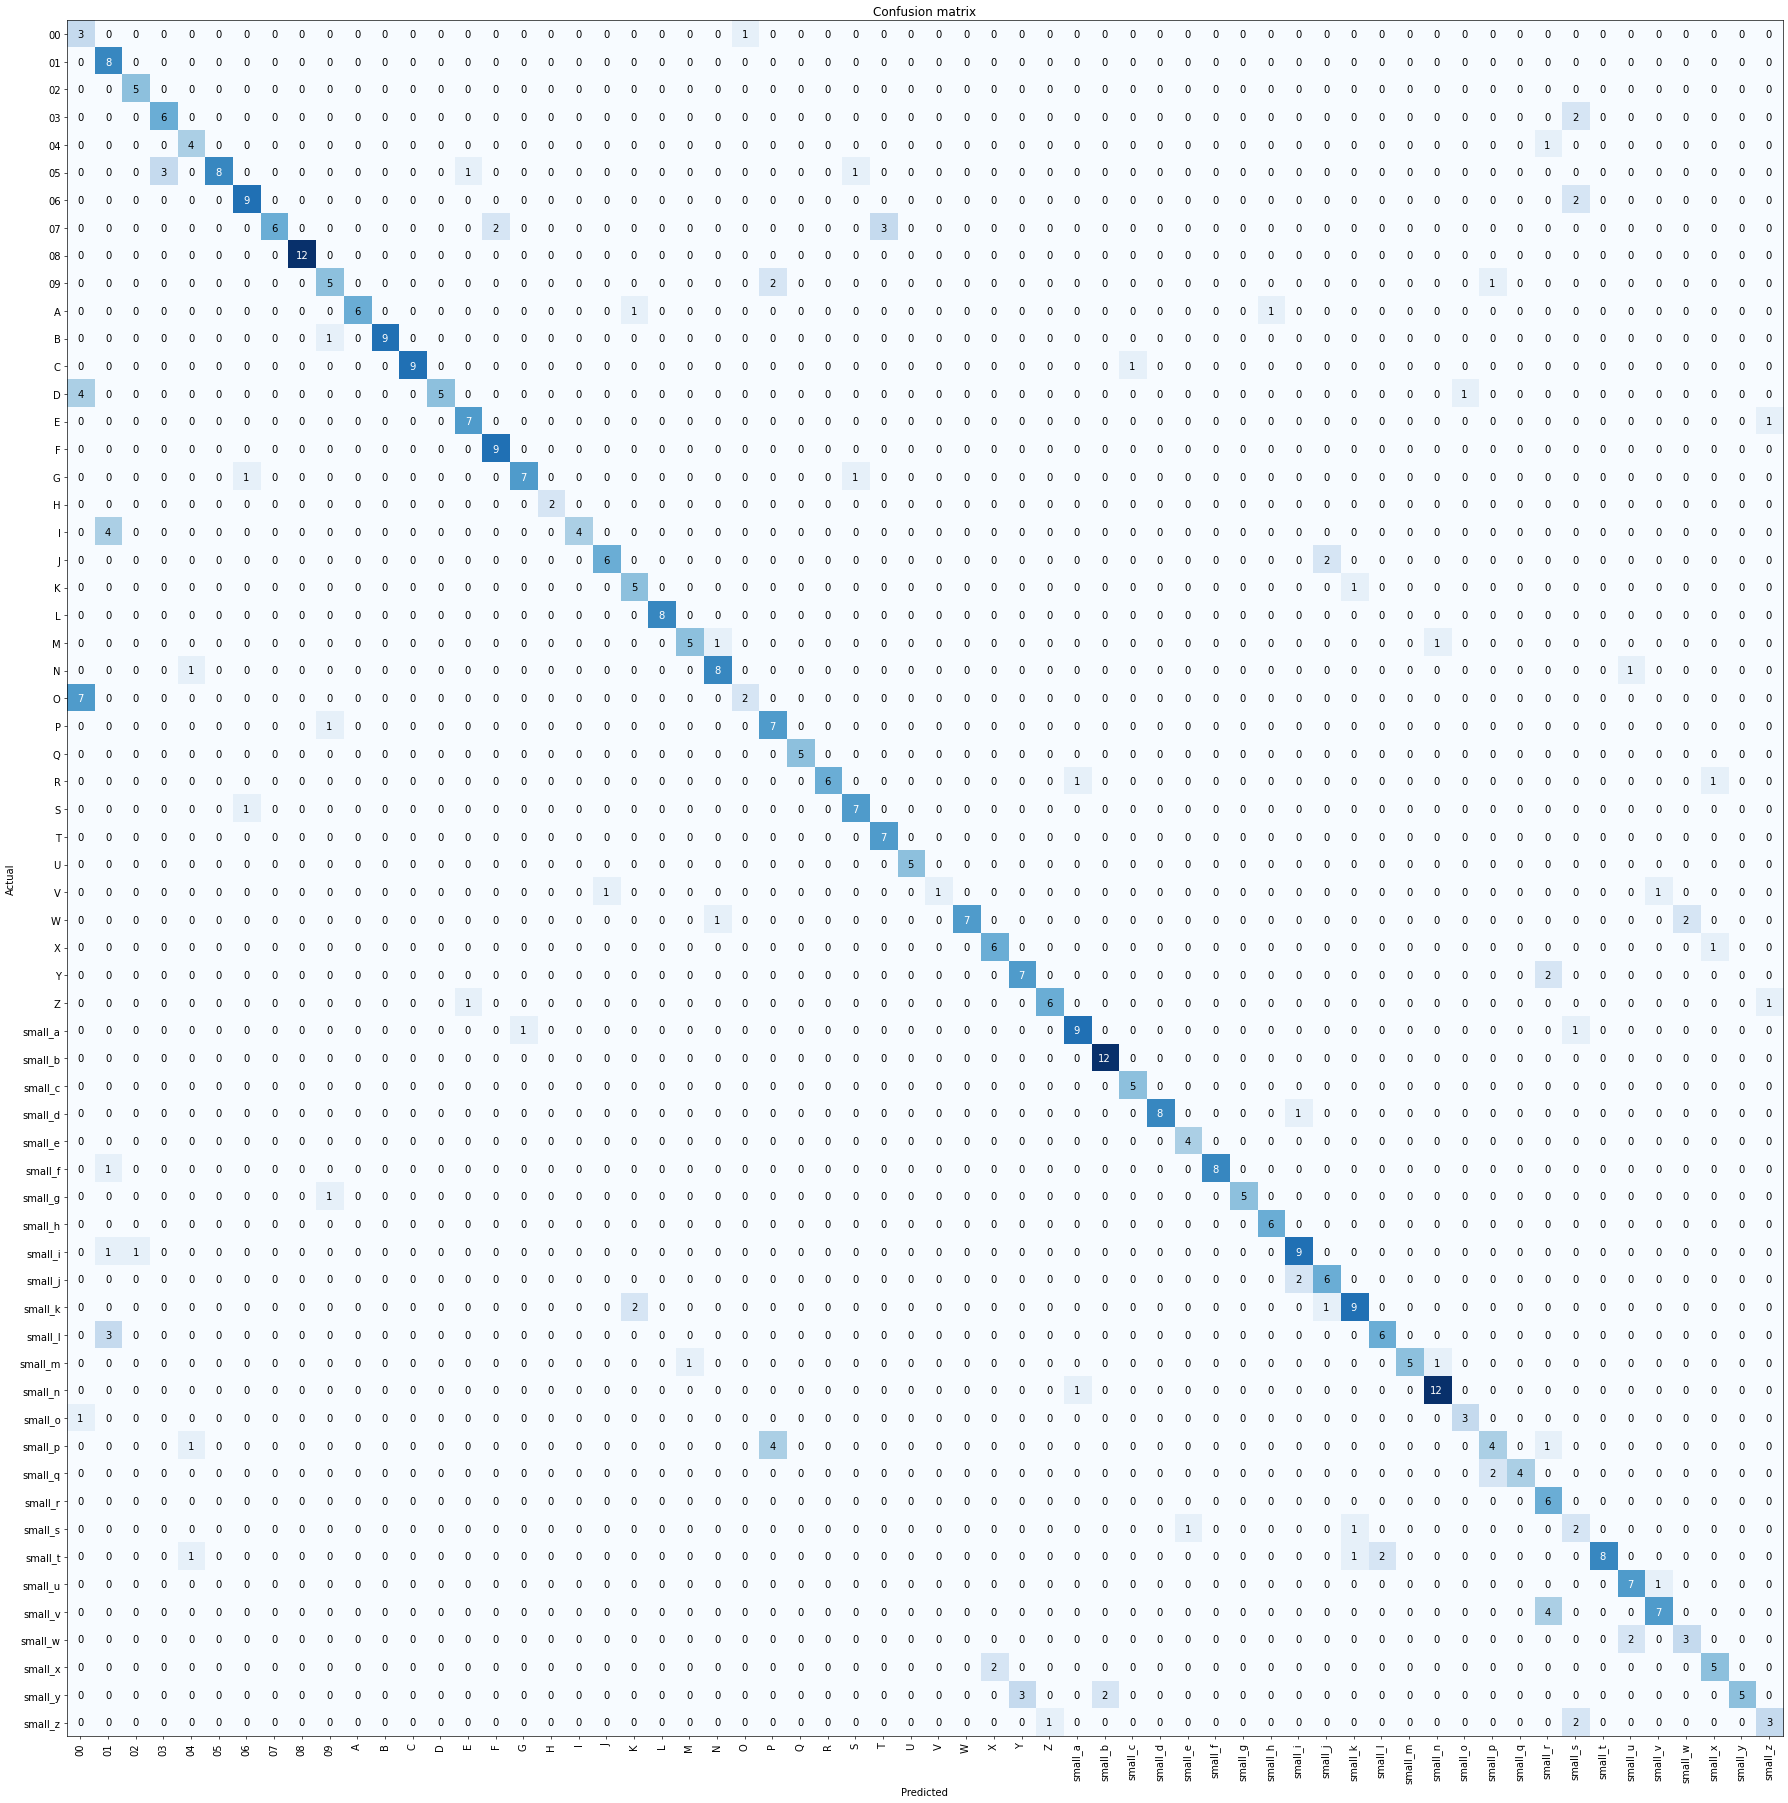

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,30), dpi=60)


In [ ]:
#confusion matrix helps us in checking the model performance : we can look at the classified values where it was wrong, where it performed.

SuggestedLRs(lr_min=9.12010818865383e-08, lr_steep=6.309573450380412e-07)

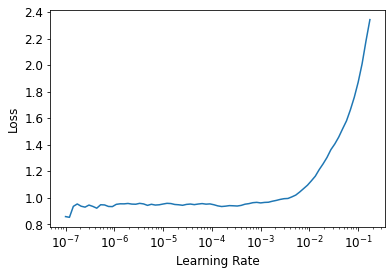

In [ ]:
#now let's try our learn_rate finder, checking if it performs well or it's same for now.
learn.lr_find()

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(),metrics=accuracy)
learn.fit_one_cycle(10,9e-7)

epoch,train_loss,valid_loss,accuracy,time
0,0.962513,0.844371,0.776210,00:51
1,0.939199,0.833361,0.782258,00:51
2,0.955941,0.826649,0.784274,00:52
3,0.959253,0.818357,0.786290,00:50
4,0.953352,0.815351,0.788306,00:58
5,0.946254,0.830586,0.780242,00:52
6,0.942294,0.822389,0.782258,00:57
7,0.941694,0.820665,0.786290,00:52
8,0.939083,0.819932,0.786290,00:52
9,0.937373,0.818628,0.784274,00:57


In [ ]:
#we could see the some imbalance here.
# nice explaination why this works : https://www.jeremyjordan.me/nn-learning-rate/

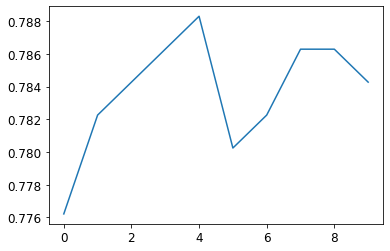

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));


SuggestedLRs(lr_min=2.290867705596611e-05, lr_steep=1.5848931980144698e-06)

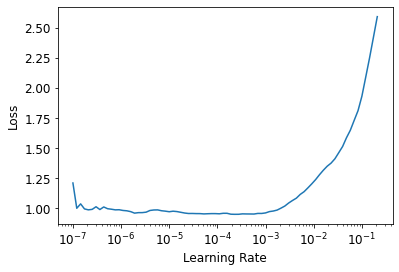

In [ ]:
learn.lr_find()

In [ ]:
#PAPER : https://arxiv.org/pdf/1812.01187.pdf tweaks in CNN's

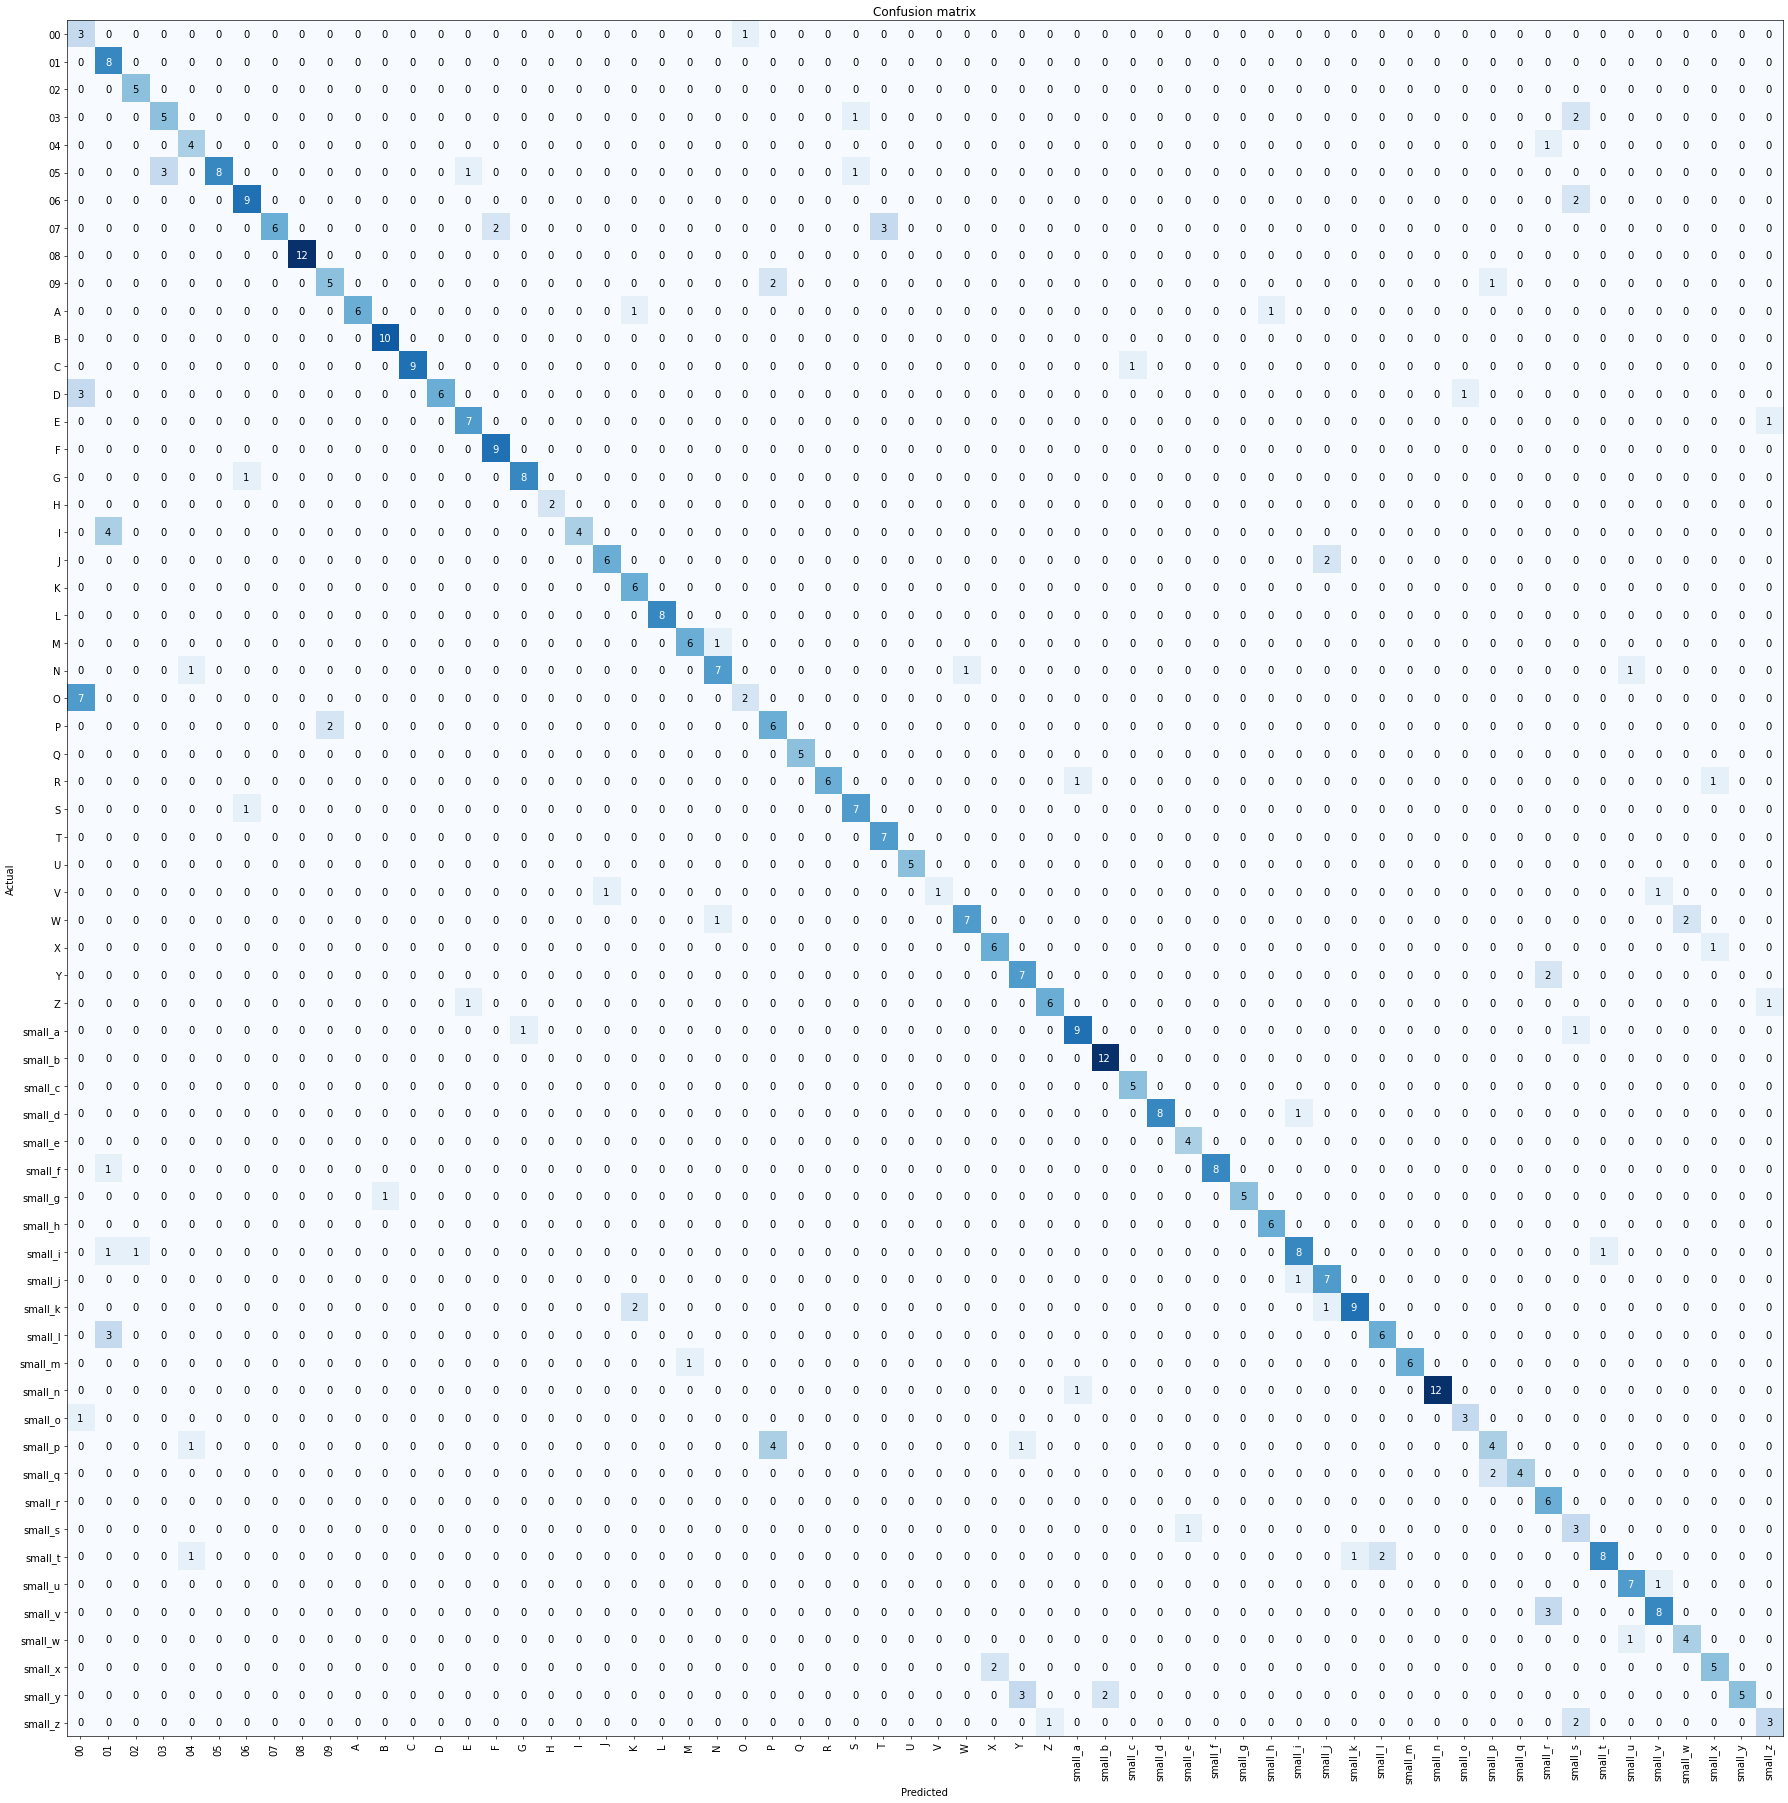

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(30,30), dpi=60)

MODEL : ResNet50

In [ ]:
model = models.resnet50(pretrained=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=0.0020892962347716093)

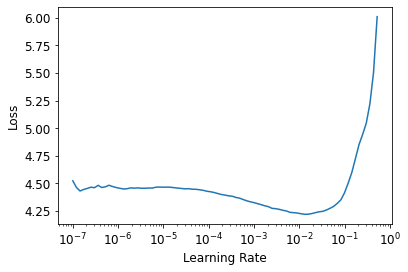

In [ ]:
#we need to change the fc layers in_features for our custom model.
body = create_body(resnet50, pretrained=False)
head = create_head(nf=2048,n_out=62)
model = nn.Sequential(body,head)

# metr = [accuracy]
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

#find the optimum lr
learn.lr_find()

In [ ]:
learn.fit_one_cycle(10,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,4.226644,6.993695,0.010081,00:53
1,4.070010,7.329491,0.024194,00:53
2,3.742105,3.569355,0.141129,00:51
3,3.218126,2.516057,0.288306,00:51
4,2.661575,1.969764,0.457661,00:51
5,2.189864,1.648126,0.508065,00:51
6,1.843493,1.339731,0.604839,00:50
7,1.556113,1.129433,0.675403,00:51
8,1.322703,0.966418,0.733871,00:51
9,1.192174,0.963928,0.729839,00:51


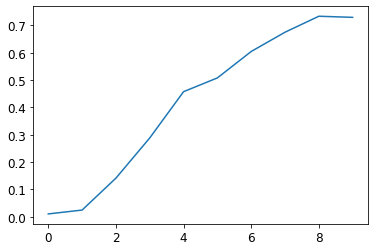

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));
# learn.lr_find()

SuggestedLRs(lr_min=2.7542287716642023e-05, lr_steep=0.00013182566908653826)

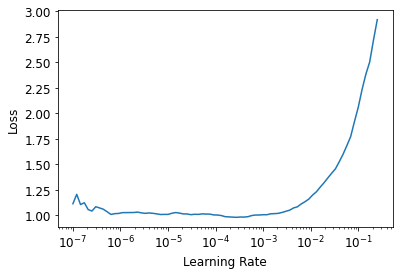

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20,2e-5)

epoch,train_loss,valid_loss,accuracy,time
0,1.009342,0.958285,0.733871,00:52
1,0.996587,0.957966,0.737903,00:52
2,0.999673,0.945935,0.745968,00:51
3,0.996612,0.934111,0.745968,00:51
4,0.995316,0.913140,0.752016,00:51
5,0.979420,0.921245,0.750000,00:51
6,0.978694,0.864714,0.766129,00:51
7,0.956846,0.877933,0.770161,00:51
8,0.939733,0.857441,0.768145,00:51
9,0.915984,0.830136,0.778226,00:51


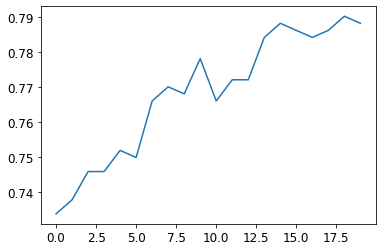

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

SuggestedLRs(lr_min=1.9054606673307718e-05, lr_steep=1.0964781722577754e-06)

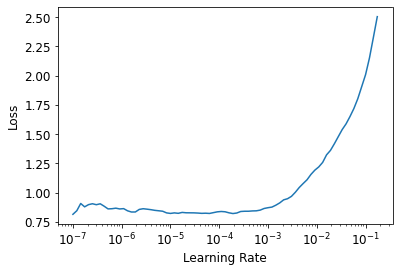

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20,lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,time
0,0.836459,0.792992,0.786290,00:52
1,0.842737,0.790369,0.788306,00:52
2,0.842448,0.797196,0.788306,00:52
3,0.843172,0.783300,0.798387,00:52
4,0.837653,0.764869,0.792339,00:52
5,0.817591,0.777429,0.788306,00:51
6,0.825365,0.776395,0.792339,00:52
7,0.816676,0.769272,0.790323,00:52
8,0.816107,0.759200,0.794355,00:51
9,0.808334,0.745682,0.798387,00:51


In [ ]:
# https://share.cocalc.com/share/32b94ee413d02759d719862907bb0a85a76c43f1/2016-11-07-175929.pdf

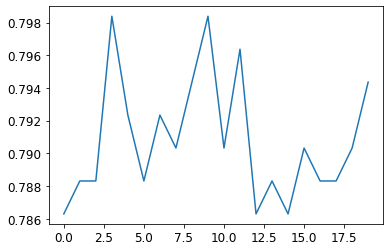

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
path = '/content/drive/MyDrive/models'

In [ ]:
cd '/content/drive/MyDrive/models'

/content/drive/MyDrive/models


In [ ]:
#saved the model for future exploration
learn.export('mark1-rn50')

In [ ]:
ls

mark1-rn50


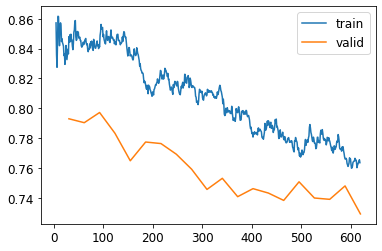

In [ ]:
learn.recorder.plot_loss()


In [ ]:
interp.plot_top_losses(10) #this seems not working...

MODEL : RESNET34

In [ ]:
model = models.resnet34(pretrained=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=6.309573450380412e-07)

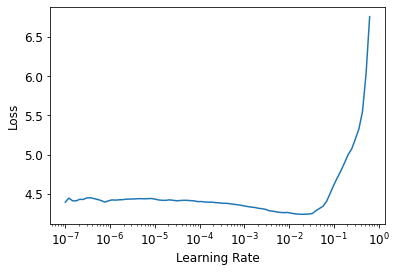

In [ ]:
#we need to change the fc layers in_features for our custom model.
body = create_body(resnet34, pretrained=False)
head = create_head(nf=512,n_out=62)
model = nn.Sequential(body,head)

# metr = [accuracy]
learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

#find the optimum lr
learn.lr_find()

In [ ]:
learn.fit_one_cycle(20,1e-03)

epoch,train_loss,valid_loss,accuracy,time
0,4.313445,4.873773,0.010081,00:48
1,4.157425,4.676472,0.042339,00:48
2,3.844648,6.369950,0.036290,00:48
3,3.342386,2.697374,0.213710,00:48
4,2.784516,2.050871,0.368952,00:48
5,2.287928,2.172623,0.326613,00:47
6,1.877815,2.320211,0.336694,00:48
7,1.555637,1.681810,0.477823,00:47
8,1.338068,1.978536,0.401210,00:48
9,1.162984,1.167258,0.633065,00:48


In [ ]:
# learn.export('mark2-rs34')

In [ ]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,0.451095,0.628383,0.796371,00:48
1,0.689425,22.806213,0.018145,00:48
2,0.919918,1.682788,0.524194,00:48
3,0.904086,1.066139,0.665323,00:48
4,0.837363,1.088877,0.687500,00:48
5,0.757076,1.110551,0.655242,00:48
6,0.660054,0.570731,0.830645,00:48
7,0.576323,0.480766,0.848790,00:48
8,0.511594,0.447607,0.862903,00:48
9,0.455133,0.435142,0.872984,00:48


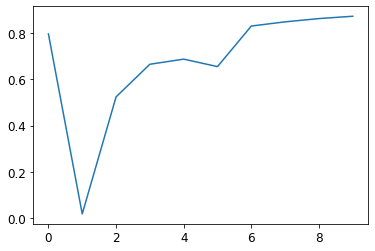

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

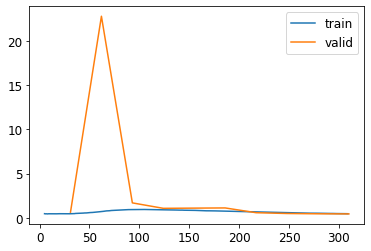

In [ ]:
learn.recorder.plot_loss()


In [ ]:
import torch


In [ ]:
os.getcwd()

'/content/drive/My Drive/models'

In [19]:
torch.load('mark1-rn50')

In [ ]:
n = torch.load('mark1-rn50')

In [ ]:
n.predict('/content/drive/MyDrive/train/00/img001-034.png')

("['06', 'small_z', '00', '00', 'small_z', '00', '01', 'small_z', '01', '01', 'small_z', '00', '01', '00', 'small_z', 'small_y', '01', 'small_x', 'small_z', 'small_z', 'small_w', 'small_z', 'small_y', 'small_y', '01', '00', '01', 'small_y', '00', 'small_z', 'small_z', 'small_z', 'small_z', 'small_x', 'small_y', '00', '03', '00', '03', '00', '04', 'small_z', '01', 'small_y', 'small_z', 'small_z', 'small_y', 'small_z', '00', '01', '06', '00', '02', '00', '04', 'small_z', '00', '00', '01', '00', '00', '02']",
 tensor([ 6.1616, -1.2511,  0.6515,  0.5971, -1.9163, -0.4366,  1.7933, -1.9340,  1.4852,  1.8126, -1.1388,  0.9562,  1.2299,  0.9988, -1.6752, -2.1752,  1.8439, -3.6658, -1.1653, -1.1036, -4.4606,
         -1.2622, -2.2758, -2.2626,  1.8531,  0.3598,  1.8151, -2.0123,  0.5035, -1.6613, -1.5753, -1.9365, -1.6207, -3.1318, -2.8909, -0.8487,  3.5627, -0.1165,  3.9848, -0.9175,  4.1711, -1.9961,
          1.7430, -2.6418, -1.3518, -1.7391, -2.9294, -1.9584,  0.3780,  1.3036,  6.2887,  0

In [14]:
cd models

/content/drive/My Drive/models


In [21]:
learn_inf = load_learner('test.pkl')


In [25]:
pil = PILImage.create('/content/drive/MyDrive/train/M/img023-002.png')
learn_inf.predict(pil)

("['00', '00', 'small_x', 'small_w', '00', 'small_x', 'small_y', 'small_y', 'small_y', '00', '04', '00', 'small_y', '00', 'small_x', 'small_y', 'small_z', '04', 'small_y', 'small_v', '01', 'small_z', 'B', '08', '00', '00', '00', '02', 'small_y', '00', '00', '00', '03', '00', '00', 'small_x', '01', 'small_y', 'small_z', 'small_z', '00', 'small_y', '00', '03', 'small_y', 'small_w', '00', 'small_z', '06', '06', '00', '02', '03', '03', 'small_x', 'small_x', '01', '00', '02', '00', 'small_z', 'small_v']",
 tensor([ 0.6146,  0.3988, -3.8104, -4.4452,  0.2931, -3.9598, -2.6426, -2.9577, -2.0958,  0.9821,  4.3216,  0.4178, -2.2929, -0.6644, -3.2411, -2.2352, -1.7870,  4.8624, -2.3239, -5.5669,  1.1655,
         -1.9567, 11.9606,  8.0270,  0.8465, -0.4722,  0.6096,  2.0035, -2.5745,  0.6914, -0.0565, -0.9749,  3.1484, -0.2354, -0.3437, -3.4438,  1.5907, -2.2170, -1.8766, -1.6845, -0.4557, -2.9219,
          0.1647,  3.4574, -2.1979, -4.7897, -0.3809, -1.7195,  6.4402,  6.5953,  0.7785,  2.3135,

In [ ]:
f = plt.imread('/content/drive/MyDrive/train/M/img023-002.png')

In [ ]:
len(m[0])
torch.argmax(m[2])


tensor(22)

In [ ]:
len(m[2])

62

In [ ]:
learn_inf.dls.vocab[61]

'small_z'

VGG Model Test

In [ ]:
# #we need to change the fc layers in_features for our custom model.
# body = create_body(resnet34, pretrained=False)
# head = create_head(nf=512,n_out=62)
# model = nn.Sequential(body,head)

# # metr = [accuracy]
# learn = Learner(dls, model, loss_func=nn.CrossEntropyLoss(),metrics=accuracy)

# #find the optimum lr
# learn.lr_find()

In [ ]:
model = models.vgg11_bn(pretrained=False)
model


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

CUSTOM PYTORCH MODEL FOR MNIST

In [1]:
#starting with the basis model:
import torch 
from torch import optim
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

In [39]:
#ResNet
class ResNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.l1 = nn.Linear(224*224,64)
    self.l2 = nn.Linear(64,64)
    self.l3 = nn.Linear(64,10)
    self.do = nn.Dropout(0.1)
  
  def forward(self, x):
    h1 = nn.functional.relu(self.l1(x))
    h2 = nn.functional.relu(self.l2(h1))
    do = self.do(h2 + h1)
    logits = self.l3(do)
    return logits
  
model = ResNet().cuda()

In [40]:
#optimizer
optimizer = optim.SGD(model.parameters(),lr=1e-2)
#Loss
loss = nn.CrossEntropyLoss()

In [41]:
#train, val slit
# train_data = None
# train, val = random_split(train_data, [55000,5000])
# train_loader = DataLoader(train, batch_size=32)
# val_loader = DataLoader(val, batch_size=32)

In [ ]:
#My Training and validation loops 
nb_epochs = 10
for epoch in range(nb_eopchs):
    losses = list()
    accuracies = list()
    model.train() #because we use dropout
    for batch in train_loader:
      x,y = batch
      #tranform to pass to linear layer
      b = x.size(0)
      x = x.view(b,-1).cuda()

      #logit
      l = model(x)
      
      #compute the objective function, measure the task for classification
      J = loss(l,y).cuda()

      #cleaning the gradient
      model.zero_grad()
      # optimizer.zero_grad()

      #compute the partial derivative WRT params
      J.backward()

      #step in the opposite direction of gradient
      optimizer.step()

      losses.append(J.item())
      accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())

    print(f'Epoch {epoch+1}', end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}',end=',')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')


    losses = list()
    accurcies = list()
    for batch in val_loader:
      x,y = batch
      #tranform to pass to linear layer
      b = x.size(0)
      x = x.view(b,-1).cuda()

      #logit
      with torch.no_grad():
        l = model(x)
      
      #compute the objective function, measure the task for classification
      J = loss(l,y.cuda())
      losses.append(J.item())
      accuracies.append(y.eq(l.detach().argmax(dim=1).cpu()).float().mean())
  
    print(f'Epoch {epoch+1}', end=', ')
    print(f'validation loss: {torch.tensor(losses).mean():.2f}',end=',')
    print(f'validation accuracy: {torch.tensor(accuracies).mean():.2f}')

In [16]:
path = untar_data('https://drive.google.com/file/d/1l7YWv1RXSXkdb4RN_HA2WuQPAgeIBN1p/')

In [20]:
!wget('https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0')

/bin/bash: -c: line 0: syntax error near unexpected token `'https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0''
/bin/bash: -c: line 0: `wget('https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0')'


In [21]:
!wget https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0

--2021-04-10 17:31:59--  https://www.dropbox.com/s/otc12z2w7f7xm8z/mnistTask3.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/otc12z2w7f7xm8z/mnistTask3.zip [following]
--2021-04-10 17:31:59--  https://www.dropbox.com/s/raw/otc12z2w7f7xm8z/mnistTask3.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4422cf55af805ad73a2b7366c6.dl.dropboxusercontent.com/cd/0/inline/BMXjVpv06S_TDzTbvafWhNno7-18yoPpo3SzVUb8HldNPEQB5vpQsv7CK-TqMhUmo_1ERUAjHWj3hI1Q4oiwX8ancOCA5Pj7BCmrEv5dDQDTu2Mww3qNezDWNtTY-t7dkdZScWLK6U0kTgBu1AvH7u5K/file# [following]
--2021-04-10 17:31:59--  https://uc4422cf55af805ad73a2b7366c6.dl.dropboxusercontent.com/cd/0/inline/BMXjVpv06S_TDzTbvafWhNno7-18yoPpo3SzVUb8HldNPEQB5vpQsv7CK-TqMhUmo_1ERUAjHWj3hI1

In [22]:
ls

 drive/  'mnistTask3.zip?dl=0'   sample_data/


In [23]:
!unrar mnistTask3.zip


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Usage:     unrar <command> -<switch 1> -<switch N> <archive> <files...>
               <@listfiles...> <path_to_extract\>

<Commands>
  e             Extract files without archived paths
  l[t[a],b]     List archive contents [technical[all], bare]
  p             Print file to stdout
  t             Test archive files
  v[t[a],b]     Verbosely list archive contents [technical[all],bare]
  x             Extract files with full path

<Switches>
  -             Stop switches scanning
  @[+]          Disable [enable] file lists
  ad            Append archive name to destination path
  ag[format]    Generate archive name using the current date
  ai            Ignore file attributes
  ap<path>      Set path inside archive
  c-            Disable comments show
  cfg-          Disable read configuration
  cl            Convert names to lower case
  cu            Convert names to upper case
  dh            Open shared files
  e

In [24]:
!unrar mnistTask3.zip?dl=0


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal

Usage:     unrar <command> -<switch 1> -<switch N> <archive> <files...>
               <@listfiles...> <path_to_extract\>

<Commands>
  e             Extract files without archived paths
  l[t[a],b]     List archive contents [technical[all], bare]
  p             Print file to stdout
  t             Test archive files
  v[t[a],b]     Verbosely list archive contents [technical[all],bare]
  x             Extract files with full path

<Switches>
  -             Stop switches scanning
  @[+]          Disable [enable] file lists
  ad            Append archive name to destination path
  ag[format]    Generate archive name using the current date
  ai            Ignore file attributes
  ap<path>      Set path inside archive
  c-            Disable comments show
  cfg-          Disable read configuration
  cl            Convert names to lower case
  cu            Convert names to upper case
  dh            Open shared files
  e

In [25]:
ls

 drive/  'mnistTask3.zip?dl=0'   sample_data/


In [28]:
ls

 drive/   mnistTask/  'mnistTask3.zip?dl=0'   sample_data/


In [29]:
!pwd

/content


In [31]:
path = '/content/mnistTask/'

In [32]:
AlphaNumeric = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(460),
    batch_tfms=aug_transforms(size=224, min_scale=0.75)
)

In [33]:
dls = AlphaNumeric.dataloaders(path)

In [34]:
dls.one_batch()

(TensorImage([[[[1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 2.0839e-02, 2.6252e-02, 3.1955e-02],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 2.2574e-02, 2.3790e-02, 2.8467e-02],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 2.2684e-02, 2.2890e-02, 2.5592e-02],
           ...,
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 1.1323e-07, 1.1323e-07, 1.1323e-07],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 1.1323e-07, 1.1323e-07, 1.1323e-07],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 1.1323e-07, 1.1323e-07, 1.1323e-07]],
 
          [[1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 2.0839e-02, 2.6252e-02, 3.1955e-02],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 2.2574e-02, 2.3790e-02, 2.8467e-02],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 2.2684e-02, 2.2890e-02, 2.5592e-02],
           ...,
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  ..., 1.1323e-07, 1.1323e-07, 1.1323e-07],
           [1.1323e-07, 1.1323e-07, 1.1323e-07,  .